## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, MaxPool1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## Exploring Fake News

In [3]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [4]:
fake.sample(4)

,title,text,subject,date
607,Totally-Not-Running-For-President Pence Signa...,Speculation about Vice-President Mike Pence s ...,News,"August 9, 2017"
11310,KARMA! Did Meryl Streep’s Anti-Trump Rant At G...,Karma It seems to be biting a lot of anti-Trum...,politics,"Mar 24, 2017"
2383,"Trump Attacks The ‘Failing’ New York Times, B...",Donald Trump kicked off his Sunday morning by ...,News,"February 26, 2017"
6341,Antonin Scalia’s Own Past Ruling Will Hand Ob...,The Obama administration recently sent a missi...,News,"May 16, 2016"


In [5]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [6]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

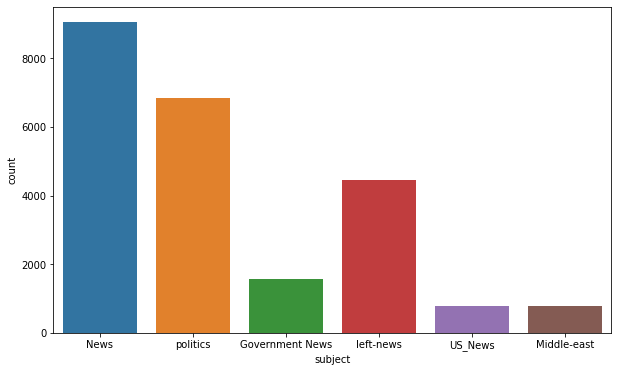

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'subject', data=fake)

## WordCloud Library
To generate image from data

In [8]:
text = ' '.join(fake['text'].tolist())

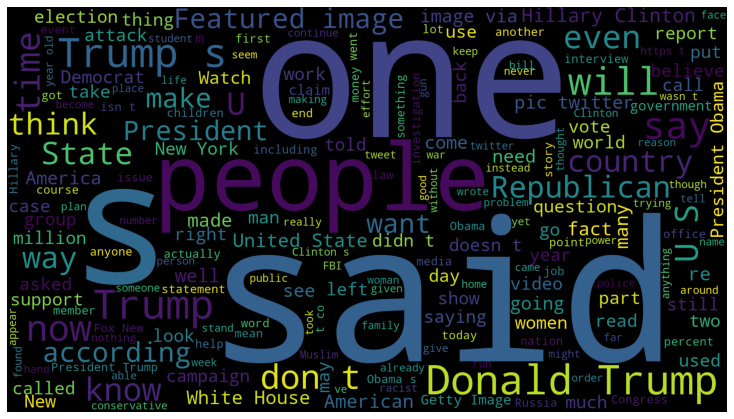

In [9]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Exploring Real News

In [10]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [11]:
real.sample(4)

,title,text,subject,date
20815,Catalonia parliament votes for Oct. 1 referend...,MADRID (Reuters) - Catalonia s parliament vote...,worldnews,"September 6, 2017"
20079,Myanmar’s Suu Kyi working to get aid to Rohing...,WASHINGTON (Reuters) - U.S. Senate Majority Le...,worldnews,"September 14, 2017"
4366,Russian PM says U.S. Syria strikes 'one step a...,MOSCOW (Reuters) - Russian Prime Minister Dmit...,politicsNews,"April 7, 2017"
4629,U.S. senator launches probe into five top opio...,(Reuters) - U.S. Democratic Senator Claire McC...,politicsNews,"March 28, 2017"


In [12]:
text = ' '.join(real['text'].tolist())

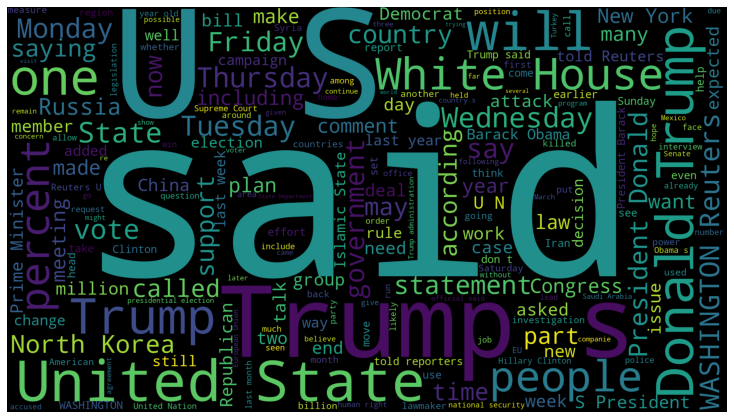

In [13]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Cleaning Data
Removing Reuters or Twitter Tweet information from text



In [14]:
real.sample(5)

,title,text,subject,date
20269,Opposition stays away as Kenyatta warns agains...,NAIROBI (Reuters) - Kenyan President Uhuru Ken...,worldnews,"September 12, 2017"
9299,"4,700 Syrian refugees approved resettlement to...",WASHINGTON (Reuters) - The United States has a...,politicsNews,"June 2, 2016"
9670,White House says Congress has no reason to wai...,WASHINGTON (Reuters) - The White House on Thur...,politicsNews,"May 5, 2016"
8737,"Fund-raising stalled, Republican convention as...",CLEVELAND (Reuters) - A handful of donors to t...,politicsNews,"July 16, 2016"
8770,CIA director says he would resign if ordered t...,WASHINGTON (Reuters) - CIA Director John Brenn...,politicsNews,"July 13, 2016"


To get unknown publishers index from real text

In [15]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit=1)

    assert(len(record[0]) < 120)

  except:
    unknown_publishers.append(index)

In [16]:
len(unknown_publishers)

221

There is an example of empty text in real text (we will drop it)

In [17]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [18]:
real = real.drop(8970, axis=0)

We will split the real text to text and publisher

In [19]:
publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')

  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [20]:
real['publisher']=publisher
real['text']=tmp_text

In [21]:
real.sample(4)

,title,text,subject,date,publisher
8562,Factbox: Gold Stars mark sacrifices of U.S. mi...,A war of words between Donald Trump and the pa...,politicsNews,"August 1, 2016",(Reuters)
496,Consumer agency official English says will be ...,"Leandra English, who is in a legal battle with...",politicsNews,"November 28, 2017",WASHINGTON (Reuters)
12012,"As Syrian couples say 'I do,' Lebanon says 'No...","In a tent in Lebanon surrounded by snow, Syria...",worldnews,"December 18, 2017","BEKAA, Lebanon (Reuters)"
1173,Trump backs away from bipartisan Senate health...,U.S. President Donald Trump on Wednesday backe...,politicsNews,"October 18, 2017",WASHINGTON (Reuters)


There are empty text in fake text

In [22]:
empty_fake_index = [index for index, text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [23]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


So we will concat the title and the text culomns in text culomn

In [24]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [25]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

## Preprocessing Text
initialize data

In [26]:
real['class'] = 1
fake['class'] = 0

In [27]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [28]:
real = real[['text', 'class']]
fake = fake[['text', 'class']]

In [29]:
data = real.append(fake, ignore_index=True)

In [30]:
data.sample(4)

,text,class
4328,tillerson cites russian inaction as helping to...,1
25034,watch: mike pence’s neighbors troll him with ...,0
25733,white supremacist pac launches radio ad touti...,0
31427,video: hateful nyc ‘artists’ slip new ‘items’ ...,0


## Download preprocess_kgptalkie Library
To remove the special chars

In [31]:
# https://github.com/laxmimerit/preprocess_kgptalkie

In [32]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup==4.9.1
!pip install textblod==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.4 MB 18.3 MB/s 
     |████████████████████████████████| 184 kB 61.5 MB/s 
     |████████████████████████████████| 2.2 MB 54.8 MB/s 
     |████████████████████████████████| 3.7 MB 57.3 MB/s 
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.4
    Uninstalling srsly-2.4.4:
      Successfully uninstalled srsly-2.4.4
  Attempting uninstall: blis
    Found existing installation: blis 0.7.8
    Uninstalling blis-0.7.8:
      Successfully uninstalled blis-0.7.8
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.0
    Uninstalling thinc-8.1.0:
      Successfully uninstalled thinc-8.1.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.8
    Uninstalling catalogue-2.0.8:
      Successfully uninstalled catalogue-2.0.8
  Attempting uninstall: spacy
    Found existing installation: s

In [33]:
import preprocess_kgptalkie as ps

In [34]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [35]:
ps.remove_special_chars('I ,@m H#ppy')

'I m Hppy'

## Size Of Data Set

In [36]:
data.shape

(44897, 2)

## Vectorization -- Word2Vec
To convert the word to vector

In [37]:
import gensim

In [38]:
y = data['class'].values

In [39]:
X = [d.split() for d in data['text'].tolist()]

In [40]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

Run The model to convert the words in text to vectors

In [41]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=DIM, window=10, min_count=1)

Number of total vocabulary

In [42]:
len(w2v_model.wv.vocab)

231872

In [43]:
w2v_model['sun']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 5.7309759e-01, -6.7248410e-01,  8.2544816e-01, -1.3053147e-01,
        6.1016083e-01, -7.9312837e-01, -6.6145921e-01, -3.4776807e-01,
       -1.5285256e+00, -2.9042009e-01,  2.3628173e-02, -4.2625830e-02,
        4.9001947e-02,  1.7067999e-01, -1.3866304e-02, -1.8648019e+00,
       -1.1817223e+00, -9.2480499e-01,  4.0770569e-01, -4.1937116e-01,
       -8.0766493e-01,  1.2765063e+00, -5.4607826e-01,  3.9783415e-01,
       -1.2992926e+00,  7.6688135e-01,  3.5474551e-01, -3.3479261e-01,
       -9.2616983e-02, -1.7621684e-01, -5.7793181e-02, -1.2129894e-01,
       -5.5473769e-01, -4.5616794e-01, -3.0339673e-01,  8.1951588e-01,
       -1.3731002e+00, -1.4402536e+00, -3.5535380e-01, -8.5162866e-01,
       -1.0768996e-01, -1.4570559e+00,  1.4268938e-01,  1.1838385e+00,
        1.0386351e+00,  4.5498040e-01, -4.1643869e-02, -5.0742091e-03,
       -2.3931920e-04, -5.4857498e-01, -2.9462743e-01, -6.4989942e-01,
        4.7492072e-01, -2.1448598e+00, -9.4728869e-01,  1.2576931e+00,
      

In [44]:
w2v_model['germany']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.76900804,  3.0183904 , -0.5701309 , -1.1739045 ,  1.3410696 ,
        0.16189694,  2.6242154 , -2.6206937 ,  1.3813152 ,  0.882708  ,
       -1.0423001 ,  3.2843487 , -0.5687518 , -0.05181793, -1.9043291 ,
       -3.6586525 , -4.2783356 ,  0.62993604,  0.6771881 ,  0.1392804 ,
       -2.2597942 , -2.5782998 ,  0.5408469 , -0.7190579 , -3.3217835 ,
       -0.23611128,  4.5187597 , -0.7311558 , -1.9446024 , -0.6864756 ,
        2.3495834 ,  1.3049138 , -0.61612695,  3.2448504 ,  0.96962005,
       -2.3793125 , -5.2247214 ,  1.0929822 ,  2.0030847 , -0.5538837 ,
        0.08098307, -0.02455506, -2.532695  ,  2.9687486 , -0.26819557,
       -1.3318976 , -1.7311465 ,  0.38256446,  1.9454352 , -1.8021303 ,
        2.219062  , -1.2306117 , -1.0200735 , -1.3755858 ,  3.5015304 ,
       -0.7130698 , -0.3037004 ,  3.1115289 , -3.5072384 ,  3.175846  ,
       -0.25682086, -2.2759795 , -1.5797834 , -1.2924007 , -3.3166416 ,
        1.0132022 ,  1.9872957 , -1.0473728 ,  1.5916888 , -2.83

In [45]:
w2v_model.wv.most_similar('high')

[('low', 0.6819205284118652),
 ('highest', 0.5888888239860535),
 ('rising', 0.5380648374557495),
 ('floridastarting', 0.5028003454208374),
 ('parentscarson', 0.45355647802352905),
 ('elevated', 0.4531742036342621),
 ('lowest', 0.45295482873916626),
 ('inflation', 0.44565826654434204),
 ('unemployment', 0.4439988136291504),
 ('elementary', 0.44306597113609314)]

We will convert The text to sequence of numbers

In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [47]:
X = tokenizer.texts_to_sequences(X)

In [48]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

Word count greater than 1000

In [49]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1581

Padded the text to be 1000 words

In [50]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [51]:
len(X[200])

1000

In [52]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

Initial weight matrix from w2v_model

In [53]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [54]:
embedding_vectors = get_weight_matrix(w2v_model)

In [55]:
embedding_vectors.shape

(231873, 100)

# Build Our Neural Network

In [56]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         23187300  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 23,304,677
Trainable params: 117,377
Non-trainable params: 23,187,300
_________________________________________________________________


Split the data to train and test

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Start training

In [59]:
his = model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 48s 55ms/step - loss: 0.1571 - acc: 0.9406 - val_loss: 0.2009 - val_acc: 0.9191
Epoch 2/6
737/737 [==============================] - 40s 54ms/step - loss: 0.0924 - acc: 0.9687 - val_loss: 0.0687 - val_acc: 0.9783
Epoch 3/6
737/737 [==============================] - 40s 54ms/step - loss: 0.0414 - acc: 0.9865 - val_loss: 0.0643 - val_acc: 0.9767
Epoch 4/6
737/737 [==============================] - 40s 54ms/step - loss: 0.0329 - acc: 0.9901 - val_loss: 0.0318 - val_acc: 0.9904
Epoch 5/6
737/737 [==============================] - 40s 54ms/step - loss: 0.0182 - acc: 0.9941 - val_loss: 0.0320 - val_acc: 0.9915
Epoch 6/6
737/737 [==============================] - 40s 54ms/step - loss: 0.0086 - acc: 0.9973 - val_loss: 0.0259 - val_acc: 0.9921


## Learning And Validation Curves

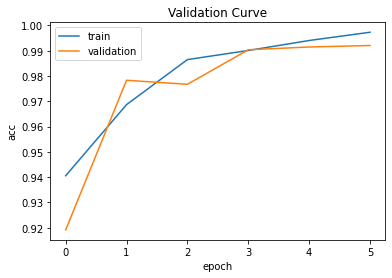

In [60]:
plt.plot(his.history['acc'])
plt.plot(his.history['val_acc'])
plt.title('Validation Curve')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

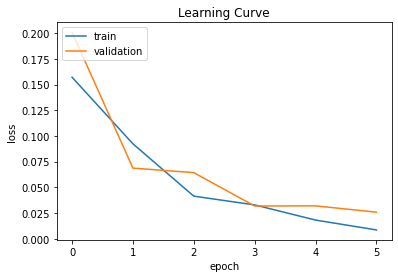

In [61]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Learning Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [62]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

In [63]:
accuracy_score(y_test, y_pred)

0.9915367483296214

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5818
           1       1.00      0.99      0.99      5407

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



## Test A Example

In [65]:
x = ['Hello just me']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [66]:
(model.predict(x) >= 0.5).astype(int)

array([[0]])

In [67]:
x = ['As many as 3,79,257 more people tested positive for Covid-19 in the last 24 hours, taking the cumulative caseload to 1,83,76,524, said the Union health ministry on Thursday morning. This is the biggest spike in new cases the country has see as it continues to reel under an alarming second wave. Maharashtra continues to be the biggest contributor']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [70]:
(model.predict(x) >= 0.5).astype(int)[0][0]

1